# Getting started with statsmodels

## Setup libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pandas as pd
from patsy import dmatrices

## Geta data

In [2]:
df = sm.datasets.get_rdataset('Guerry', 'HistData').data

In [3]:
print(f'(rows, cols) = {df.shape}')

(rows, cols) = (86, 23)


In [4]:
df.columns

Index(['dept', 'Region', 'Department', 'Crime_pers', 'Crime_prop', 'Literacy',
       'Donations', 'Infants', 'Suicides', 'MainCity', 'Wealth', 'Commerce',
       'Clergy', 'Crime_parents', 'Infanticide', 'Donation_clergy', 'Lottery',
       'Desertion', 'Instruction', 'Prostitutes', 'Distance', 'Area',
       'Pop1831'],
      dtype='object')

In [5]:
cols = ['Department', 'Lottery', 'Literacy', 'Wealth', 'Region']

In [6]:
df = df[cols]

## Clean data

Show last five rows

In [7]:
df[-5:]

,Department,Lottery,Literacy,Wealth,Region
81,Vienne,40,25,68,W
82,Haute-Vienne,55,13,67,C
83,Vosges,14,62,82,E
84,Yonne,51,47,30,C
85,Corse,83,49,37,NaN


In [8]:
df = df.dropna()

In [9]:
df.isna().sum()

Department    0
Lottery       0
Literacy      0
Wealth        0
Region        0
dtype: int64

## Endog, exog

Endog and exog are terms used in `patsy` and the `statsmodels` package to indicate endogenous and exogenous variables. Other terms for variables are

Endog

* y variable
* left hand side
* dependent variable
* regressand
* outcome
* response variable

Exog

* x variable
* right hand side
* independent variable
* regressor
* design
* explanatory variable

## Design matrices

In [10]:
y, X = dmatrices('Lottery ~ Literacy + Wealth + Region',
                 data=df,
                 return_type='dataframe')

In [11]:
y.shape, X.shape

((85, 1), (85, 7))

In [12]:
df.dtypes

Department    object
Lottery        int64
Literacy       int64
Wealth         int64
Region        object
dtype: object

The Region variable is categorical

In [13]:
df.Region.value_counts()

W    17
N    17
C    17
S    17
E    17
Name: Region, dtype: int64

The Region variable is automatically split into 4 indicator variables

In [14]:
X.columns

Index(['Intercept', 'Region[T.E]', 'Region[T.N]', 'Region[T.S]', 'Region[T.W]',
       'Literacy', 'Wealth'],
      dtype='object')

In [15]:
y.columns

Index(['Lottery'], dtype='object')

## Model fit and summary

In [16]:
mod = sm.OLS(y, X)

In [17]:
res = mod.fit()

In [18]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Sun, 21 Mar 2021   Prob (F-statistic):           1.07e-05
Time:                        20:27:53   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

In [19]:
res.params

Intercept      38.651655
Region[T.E]   -15.427785
Region[T.N]   -10.016961
Region[T.S]    -4.548257
Region[T.W]   -10.091276
Literacy       -0.185819
Wealth          0.451475
dtype: float64

In [20]:
res.rsquared

0.3379508691928822

## Diagnostics and specification tests

Rainbow test for linearity - null hypothesis is the relationship is linear

In [21]:
sm.stats.linear_rainbow(res)  # F stat, p-value

(0.847233997615691, 0.6997965543621644)

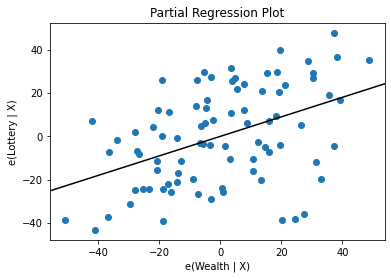

In [22]:
_ = sm.graphics.plot_partregress('Lottery',
                                 'Wealth', ['Region', 'Literacy'],
                                 data=df,
                                 obs_labels=False)

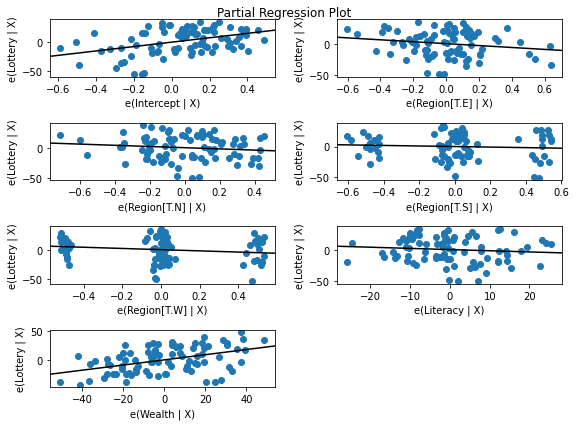

In [23]:
fig = plt.figure(figsize=(8, 6))
_ = sm.graphics.plot_partregress_grid(res, fig=fig)

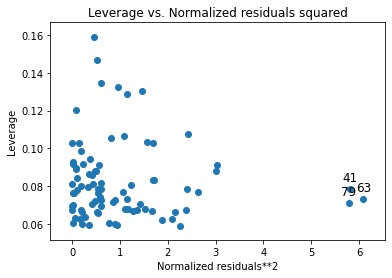

In [24]:
_ = sm.graphics.plot_leverage_resid2(res)

Residual fitted plot

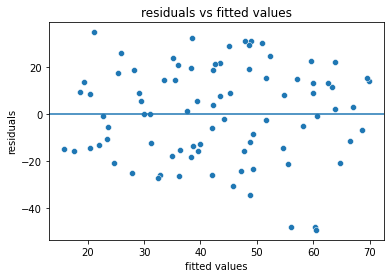

In [25]:
ax = sns.scatterplot(x=res.fittedvalues, y=res.resid)
ax.set_xlabel('fitted values')
ax.set_ylabel('residuals')
ax.axhline(0)
_ = ax.set_title('residuals vs fitted values')

The square root of residuals is better for checking constant variance

Text(0.5, 0.98, 'sqrt(residuals) vs fitted values')

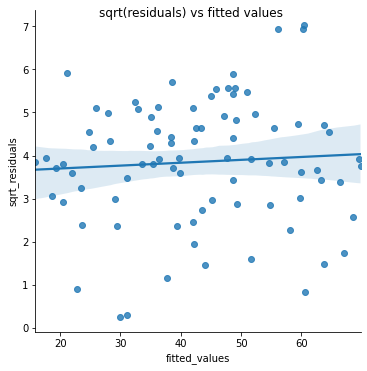

In [26]:
df = pd.DataFrame({
    'fitted_values': res.fittedvalues,
    'sqrt_residuals': np.sqrt(np.abs(res.resid))
})
g = sns.lmplot(data=df, x='fitted_values', y='sqrt_residuals')
g.fig.suptitle('sqrt(residuals) vs fitted values')

In [27]:
dres = sm.OLS(df.sqrt_residuals, sm.add_constant(df.fitted_values),
              data=df).fit()

In [28]:
dres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_residuals   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.3722
Date:                Sun, 21 Mar 2021   Prob (F-statistic):              0.543
Time:                        20:27:55   Log-Likelihood:                -150.82
No. Observations:                  85   AIC:                             305.6
Df Residuals:                      83   BIC:                             310.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5661      0.497      7.179      0.000       2.578       4.554
fitted_values     0.0067      0.011      0.610      0.543      -0.015       0.028
==============================================================================
Omnibus:                        2.165   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                1.879
Skew:                          -0.364   Prob(JB):                        0.391
Kurtosis:                       2.988   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

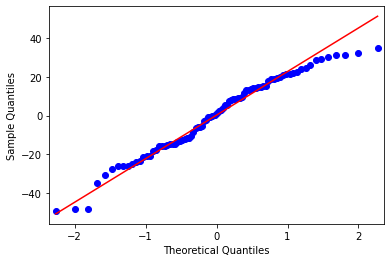

In [29]:
_ = sm.qqplot(res.resid, line='q')

Normality of the residuals

In [30]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'bSkew', 'Kurtosis']
test = sm.stats.stattools.jarque_bera(res.resid)
[f'{nt[0]} = {nt[1]:.4f}' for nt in zip(name, test)]

['Jarque-Bera = 2.6939',
 'Chi^2 two-tail prob. = 0.2600',
 'bSkew = -0.3402',
 'Kurtosis = 2.4544']